In [1]:
# Cell 1: Import Libraries and Set Random Seed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(1337)
tf.random.set_seed(1337)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.19.0


Training set shape: (500, 2)
Test set (noise=0.2) shape: (500, 2)
Test set (noise=0.1) shape: (500, 2)
Test set (noise=0.3) shape: (500, 2)


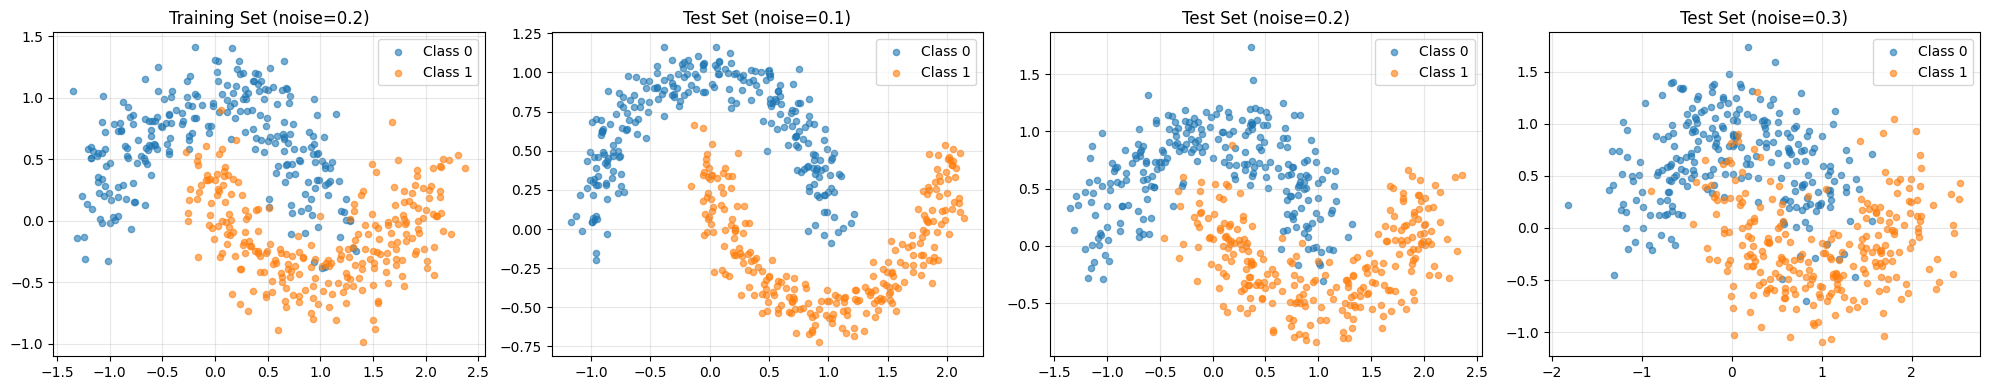

In [2]:
# Cell 2: Create Make-Moons Dataset from Scratch
def make_moons_custom(n_samples=100, noise=0.1, random_state=None):
    """
    Generate a make-moons dataset without using sklearn.

    Parameters:
    - n_samples: total number of samples
    - noise: standard deviation of Gaussian noise
    - random_state: random seed for reproducibility
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_samples_per_moon = n_samples // 2

    # Generate outer moon (class 0)
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_per_moon))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_per_moon))

    # Generate inner moon (class 1)
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_per_moon))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_per_moon)) - 0.5

    # Combine both moons
    X = np.vstack([
        np.column_stack([outer_circ_x, outer_circ_y]),
        np.column_stack([inner_circ_x, inner_circ_y])
    ])

    # Add Gaussian noise
    X += np.random.normal(0, noise, X.shape)

    # Create labels
    y = np.hstack([np.zeros(n_samples_per_moon), np.ones(n_samples_per_moon)])

    return X, y

# Generate datasets with different noise levels
np.random.seed(1337)

# Training set (noise = 0.2)
X_train_full, y_train_full = make_moons_custom(n_samples=500, noise=0.2, random_state=1337)

# Test sets with different noise levels
np.random.seed(42)  # Different seed for test sets
X_test_02, y_test_02 = make_moons_custom(n_samples=500, noise=0.2, random_state=42)

np.random.seed(43)
X_test_01, y_test_01 = make_moons_custom(n_samples=500, noise=0.1, random_state=43)

np.random.seed(44)
X_test_03, y_test_03 = make_moons_custom(n_samples=500, noise=0.3, random_state=44)

print(f"Training set shape: {X_train_full.shape}")
print(f"Test set (noise=0.2) shape: {X_test_02.shape}")
print(f"Test set (noise=0.1) shape: {X_test_01.shape}")
print(f"Test set (noise=0.3) shape: {X_test_03.shape}")

# Visualize the datasets
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

axes[0].scatter(X_train_full[y_train_full==0, 0], X_train_full[y_train_full==0, 1],
                alpha=0.6, label='Class 0', s=20)
axes[0].scatter(X_train_full[y_train_full==1, 0], X_train_full[y_train_full==1, 1],
                alpha=0.6, label='Class 1', s=20)
axes[0].set_title('Training Set (noise=0.2)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for i, (X_test, y_test, noise) in enumerate([(X_test_01, y_test_01, 0.1),
                                                (X_test_02, y_test_02, 0.2),
                                                (X_test_03, y_test_03, 0.3)]):
    axes[i+1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],
                      alpha=0.6, label='Class 0', s=20)
    axes[i+1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],
                      alpha=0.6, label='Class 1', s=20)
    axes[i+1].set_title(f'Test Set (noise={noise})')
    axes[i+1].legend()
    axes[i+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Training set size: 400
Validation set size: 100
Test set size: 500

Standardization complete!
Train mean: [-5.51780843e-16  4.07451850e-16]
Train std: [1. 1.]


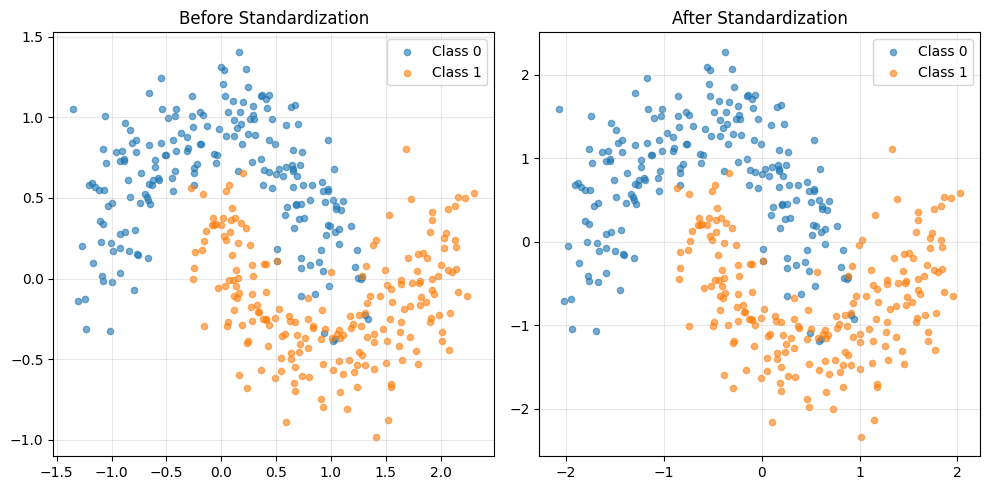

In [3]:
# Cell 3: Create Validation Split and Standardize Data
np.random.seed(1337)

# Split training data into train and validation (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=1337, stratify=y_train_full
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test_02.shape[0]}")

# Standardize using ONLY training statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_01_scaled = scaler.transform(X_test_01)
X_test_03_scaled = scaler.transform(X_test_03)

print("\nStandardization complete!")
print(f"Train mean: {X_train_scaled.mean(axis=0)}")
print(f"Train std: {X_train_scaled.std(axis=0)}")

# Visualize scaled training data
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], alpha=0.6, label='Class 0', s=20)
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], alpha=0.6, label='Class 1', s=20)
plt.title('Before Standardization')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_train_scaled[y_train==0, 0], X_train_scaled[y_train==0, 1],
            alpha=0.6, label='Class 0', s=20)
plt.scatter(X_train_scaled[y_train==1, 0], X_train_scaled[y_train==1, 1],
            alpha=0.6, label='Class 1', s=20)
plt.title('After Standardization')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Training MLP with Early Stopping...
Restoring model weights from the end of the best epoch: 500.

Training stopped at epoch: 500
Best validation accuracy: 0.9800
Total parameters: 65


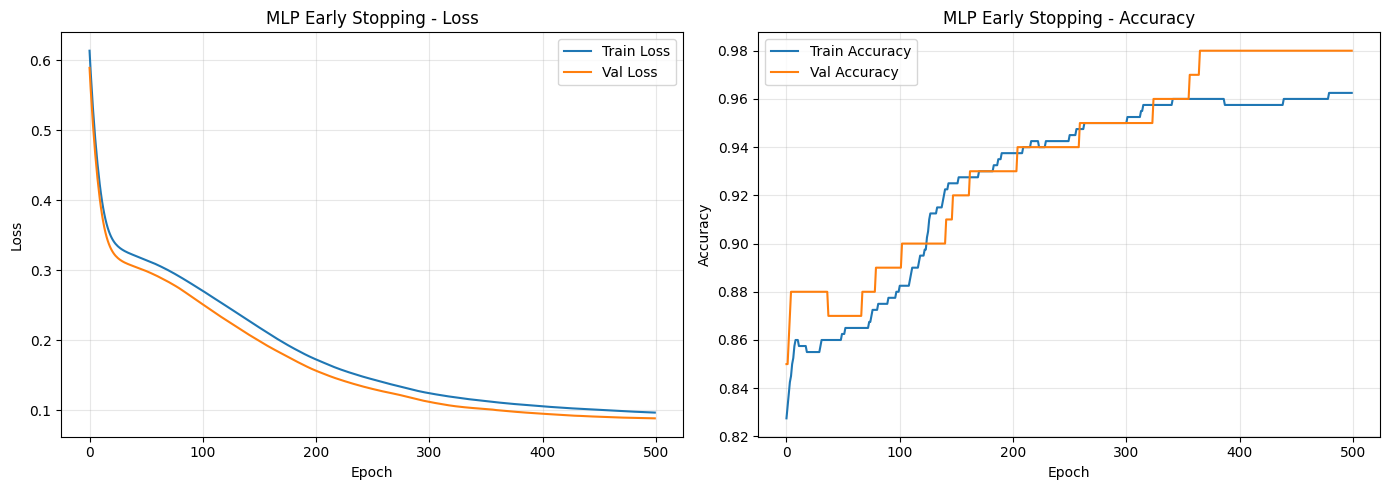

In [4]:
# Cell 4: Model 1 - MLP with Early Stopping
np.random.seed(1337)
tf.random.set_seed(1337)

# Build MLP with hidden layer
mlp_early_stop = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(2,)),
    layers.Dense(1, activation='sigmoid')
])

mlp_early_stop.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

# Train model
print("Training MLP with Early Stopping...")
history_early_stop = mlp_early_stop.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

print(f"\nTraining stopped at epoch: {len(history_early_stop.history['loss'])}")
print(f"Best validation accuracy: {max(history_early_stop.history['val_accuracy']):.4f}")

# Count parameters
total_params = mlp_early_stop.count_params()
print(f"Total parameters: {total_params}")

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_early_stop.history['loss'], label='Train Loss')
plt.plot(history_early_stop.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Early Stopping - Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_early_stop.history['accuracy'], label='Train Accuracy')
plt.plot(history_early_stop.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Early Stopping - Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store model for later evaluation
model_early_stop = mlp_early_stop

Training MLP with L1 Regularization for different lambda values...

λ=1.0e-06: Val AUROC=0.9948, Val Acc=0.9700, L1 Sparsity=0.0%, L2 Sparsity=0.0%
λ=3.0e-06: Val AUROC=0.9936, Val Acc=0.9600, L1 Sparsity=0.0%, L2 Sparsity=0.0%


λ=1.0e-05: Val AUROC=0.9944, Val Acc=0.9600, L1 Sparsity=0.0%, L2 Sparsity=0.0%
λ=3.0e-05: Val AUROC=0.9948, Val Acc=0.9600, L1 Sparsity=0.0%, L2 Sparsity=0.0%
λ=1.0e-04: Val AUROC=0.9824, Val Acc=0.9100, L1 Sparsity=12.5%, L2 Sparsity=6.2%
λ=3.0e-04: Val AUROC=0.9932, Val Acc=0.9400, L1 Sparsity=6.2%, L2 Sparsity=6.2%

Best λ: 1.0e-06 with Val AUROC: 0.9948

L1 Regularization Results:
  Lambda  Val AUROC  Val Accuracy  Layer 1 Sparsity (%)  Layer 2 Sparsity (%)
0.000001     0.9948          0.97                  0.00                  0.00
0.000003     0.9936          0.96                  0.00                  0.00
0.000010     0.9944          0.96                  0.00                  0.00
0.000030     0.9948          0.96                  0.00                  0.00
0.000100     0.9824          0.91                 12.50                  6.25
0.000300     0.9932          0.94                  6.25                  6.25


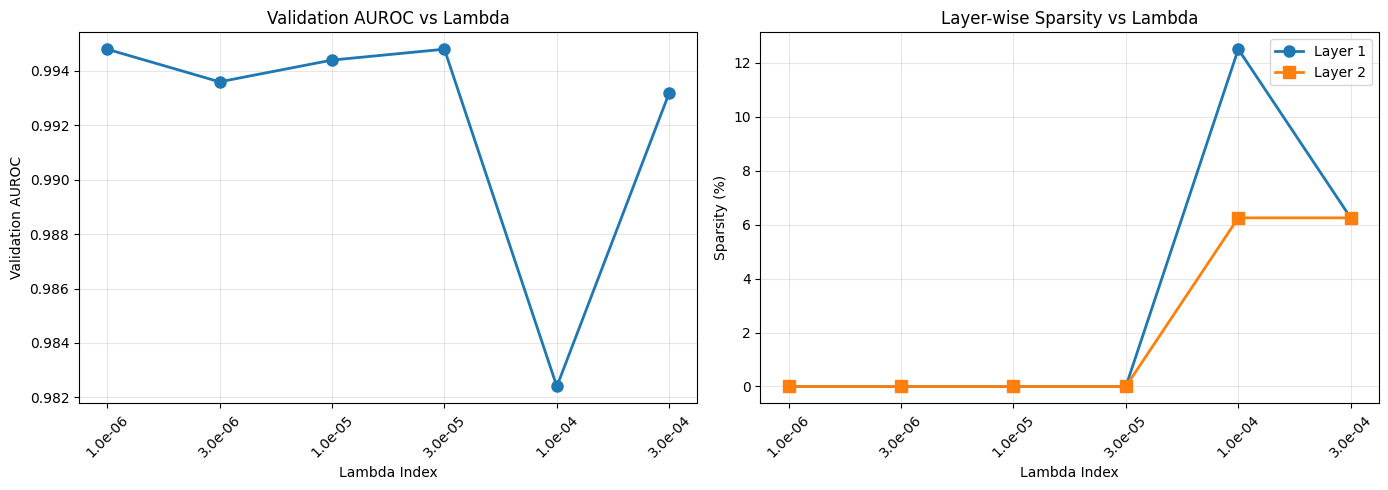


Best L1 model parameters: 65


In [5]:
# Cell 5: Model 2 - MLP with L1 Regularization
lambda_values = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]

l1_results = {
    'lambda': [],
    'val_auroc': [],
    'val_accuracy': [],
    'layer1_sparsity': [],
    'layer2_sparsity': [],
    'model': []
}

print("Training MLP with L1 Regularization for different lambda values...\n")

for lam in lambda_values:
    np.random.seed(1337)
    tf.random.set_seed(1337)

    # Build model with L1 regularization
    model_l1 = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(2,),
                    kernel_regularizer=regularizers.l1(lam)),
        layers.Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l1(lam))
    ])

    model_l1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model_l1.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=300,
        batch_size=32,
        verbose=0
    )

    # Evaluate on validation set
    y_val_pred = model_l1.predict(X_val_scaled, verbose=0).flatten()
    val_auroc = roc_auc_score(y_val, y_val_pred)
    val_acc = accuracy_score(y_val, (y_val_pred > 0.5).astype(int))

    # Calculate sparsity (percentage of weights close to zero)
    weights_layer1 = model_l1.layers[0].get_weights()[0]
    weights_layer2 = model_l1.layers[1].get_weights()[0]

    threshold = 1e-3
    sparsity_layer1 = np.mean(np.abs(weights_layer1) < threshold) * 100
    sparsity_layer2 = np.mean(np.abs(weights_layer2) < threshold) * 100

    l1_results['lambda'].append(lam)
    l1_results['val_auroc'].append(val_auroc)
    l1_results['val_accuracy'].append(val_acc)
    l1_results['layer1_sparsity'].append(sparsity_layer1)
    l1_results['layer2_sparsity'].append(sparsity_layer2)
    l1_results['model'].append(model_l1)

    print(f"λ={lam:.1e}: Val AUROC={val_auroc:.4f}, Val Acc={val_acc:.4f}, "
          f"L1 Sparsity={sparsity_layer1:.1f}%, L2 Sparsity={sparsity_layer2:.1f}%")

# Select best model based on validation AUROC
best_idx = np.argmax(l1_results['val_auroc'])
model_l1_best = l1_results['model'][best_idx]
best_lambda = l1_results['lambda'][best_idx]

print(f"\nBest λ: {best_lambda:.1e} with Val AUROC: {l1_results['val_auroc'][best_idx]:.4f}")

# Create DataFrame for results
df_l1 = pd.DataFrame({
    'Lambda': l1_results['lambda'],
    'Val AUROC': l1_results['val_auroc'],
    'Val Accuracy': l1_results['val_accuracy'],
    'Layer 1 Sparsity (%)': l1_results['layer1_sparsity'],
    'Layer 2 Sparsity (%)': l1_results['layer2_sparsity']
})

print("\nL1 Regularization Results:")
print(df_l1.to_string(index=False))

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(len(lambda_values)), l1_results['val_auroc'], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Lambda Index')
axes[0].set_ylabel('Validation AUROC')
axes[0].set_title('Validation AUROC vs Lambda')
axes[0].set_xticks(range(len(lambda_values)))
axes[0].set_xticklabels([f'{lam:.1e}' for lam in lambda_values], rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(len(lambda_values)), l1_results['layer1_sparsity'], 'o-',
             label='Layer 1', linewidth=2, markersize=8)
axes[1].plot(range(len(lambda_values)), l1_results['layer2_sparsity'], 's-',
             label='Layer 2', linewidth=2, markersize=8)
axes[1].set_xlabel('Lambda Index')
axes[1].set_ylabel('Sparsity (%)')
axes[1].set_title('Layer-wise Sparsity vs Lambda')
axes[1].set_xticks(range(len(lambda_values)))
axes[1].set_xticklabels([f'{lam:.1e}' for lam in lambda_values], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest L1 model parameters: {model_l1_best.count_params()}")

Training MLP with L2 Regularization for different lambda values...

λ=1.0e-05: Val AUROC=0.9920, Val Acc=0.9400
λ=3.0e-05: Val AUROC=0.9944, Val Acc=0.9600
λ=1.0e-04: Val AUROC=0.9948, Val Acc=0.9400
λ=3.0e-04: Val AUROC=0.9912, Val Acc=0.9400
λ=1.0e-03: Val AUROC=0.9916, Val Acc=0.9400
λ=3.0e-03: Val AUROC=0.9828, Val Acc=0.9100

Best λ: 1.0e-04 with Val AUROC: 0.9948

L2 Regularization Results:
 Lambda  Val AUROC  Val Accuracy
0.00001     0.9920          0.94
0.00003     0.9944          0.96
0.00010     0.9948          0.94
0.00030     0.9912          0.94
0.00100     0.9916          0.94
0.00300     0.9828          0.91


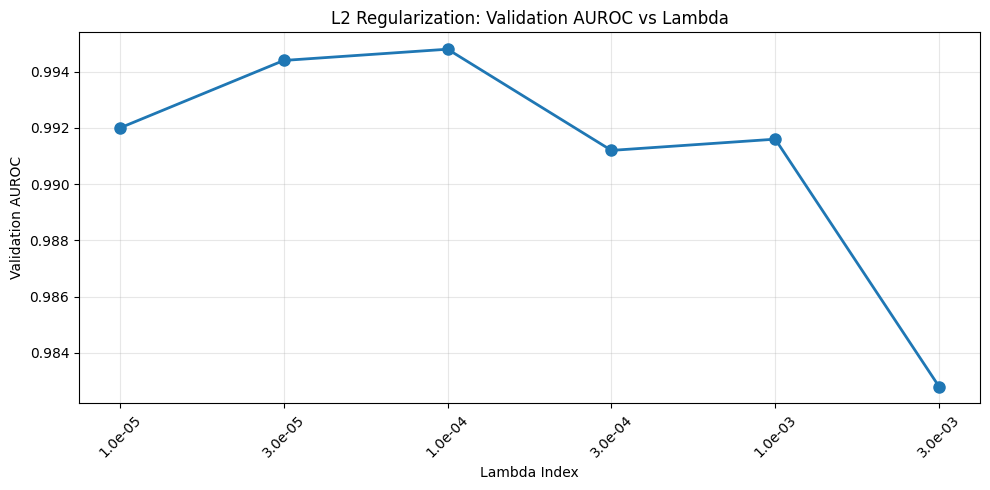


Best L2 model parameters: 65


In [6]:
# Cell 6: Model 3 - MLP with L2 Regularization
lambda_l2_values = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]

l2_results = {
    'lambda': [],
    'val_auroc': [],
    'val_accuracy': [],
    'model': []
}

print("Training MLP with L2 Regularization for different lambda values...\n")

for lam in lambda_l2_values:
    np.random.seed(1337)
    tf.random.set_seed(1337)

    # Build model with L2 regularization
    model_l2 = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(2,),
                    kernel_regularizer=regularizers.l2(lam)),
        layers.Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l2(lam))
    ])

    model_l2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model_l2.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=300,
        batch_size=32,
        verbose=0
    )

    # Evaluate on validation set
    y_val_pred = model_l2.predict(X_val_scaled, verbose=0).flatten()
    val_auroc = roc_auc_score(y_val, y_val_pred)
    val_acc = accuracy_score(y_val, (y_val_pred > 0.5).astype(int))

    l2_results['lambda'].append(lam)
    l2_results['val_auroc'].append(val_auroc)
    l2_results['val_accuracy'].append(val_acc)
    l2_results['model'].append(model_l2)

    print(f"λ={lam:.1e}: Val AUROC={val_auroc:.4f}, Val Acc={val_acc:.4f}")

# Select best model based on validation AUROC
best_idx_l2 = np.argmax(l2_results['val_auroc'])
model_l2_best = l2_results['model'][best_idx_l2]
best_lambda_l2 = l2_results['lambda'][best_idx_l2]

print(f"\nBest λ: {best_lambda_l2:.1e} with Val AUROC: {l2_results['val_auroc'][best_idx_l2]:.4f}")

# Create DataFrame for results
df_l2 = pd.DataFrame({
    'Lambda': l2_results['lambda'],
    'Val AUROC': l2_results['val_auroc'],
    'Val Accuracy': l2_results['val_accuracy']
})

print("\nL2 Regularization Results:")
print(df_l2.to_string(index=False))

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(len(lambda_l2_values)), l2_results['val_auroc'], 'o-', linewidth=2, markersize=8)
plt.xlabel('Lambda Index')
plt.ylabel('Validation AUROC')
plt.title('L2 Regularization: Validation AUROC vs Lambda')
plt.xticks(range(len(lambda_l2_values)), [f'{lam:.1e}' for lam in lambda_l2_values], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest L2 model parameters: {model_l2_best.count_params()}")

Original features: 2
Polynomial features: 5
Feature names: ['x1' 'x2' 'x1^2' 'x1 x2' 'x2^2']

Training Logistic Regression with Polynomial Features...
Validation AUROC: 0.9476
Validation Accuracy: 0.8700
Total parameters: 6


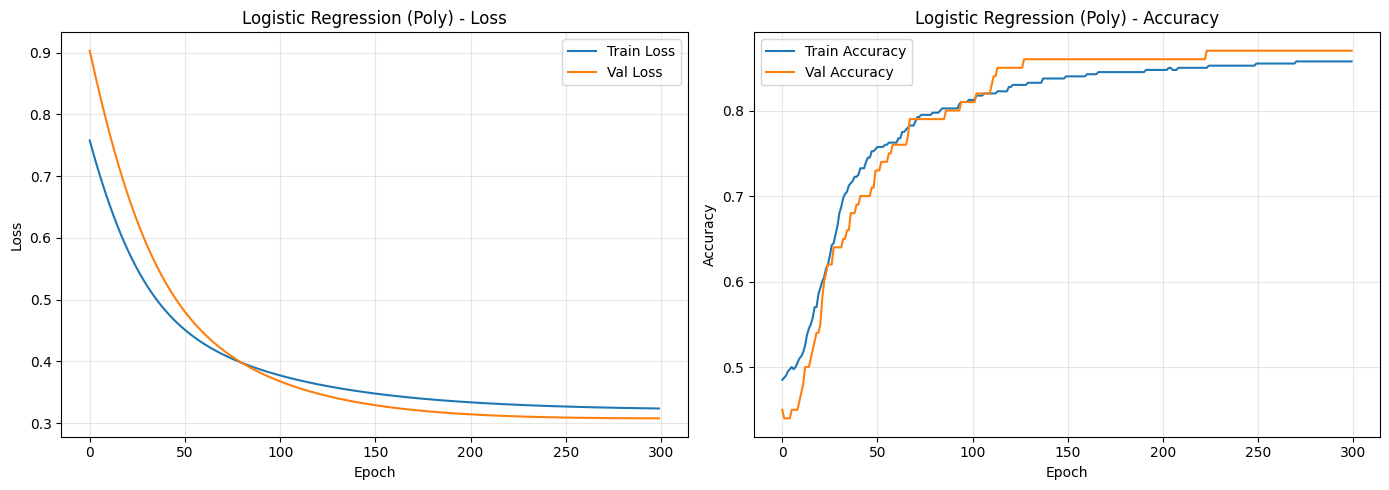

In [7]:
# Cell 7: Model 4 - Logistic Regression with Polynomial Features
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features (degree 2: x1, x2, x1^2, x1*x2, x2^2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_02_poly = poly.transform(X_test_02_scaled)
X_test_01_poly = poly.transform(X_test_01_scaled)
X_test_03_poly = poly.transform(X_test_03_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")
print(f"Feature names: {poly.get_feature_names_out(['x1', 'x2'])}")

# Build logistic regression model
np.random.seed(1337)
tf.random.set_seed(1337)

model_logistic = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_poly.shape[1],))
])

model_logistic.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
print("\nTraining Logistic Regression with Polynomial Features...")
history_logistic = model_logistic.fit(
    X_train_poly, y_train,
    validation_data=(X_val_poly, y_val),
    epochs=300,
    batch_size=32,
    verbose=0
)

# Evaluate on validation set
y_val_pred = model_logistic.predict(X_val_poly, verbose=0).flatten()
val_auroc = roc_auc_score(y_val, y_val_pred)
val_acc = accuracy_score(y_val, (y_val_pred > 0.5).astype(int))

print(f"Validation AUROC: {val_auroc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Count parameters
total_params_logistic = model_logistic.count_params()
print(f"Total parameters: {total_params_logistic}")

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_logistic.history['loss'], label='Train Loss')
plt.plot(history_logistic.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Logistic Regression (Poly) - Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_logistic.history['accuracy'], label='Train Accuracy')
plt.plot(history_logistic.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Logistic Regression (Poly) - Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Evaluate All Models on All Test Sets
def evaluate_model(model, X_test_list, y_test_list, noise_levels, model_name, use_poly=False):
    """Evaluate a model on multiple test sets"""
    results = {
        'Model': [],
        'Noise Level': [],
        'Accuracy': [],
        'AUROC': []
    }

    for X_test, y_test, noise in zip(X_test_list, y_test_list, noise_levels):
        if use_poly:
            X_test_features = poly.transform(X_test)
        else:
            X_test_features = X_test

        y_pred_prob = model.predict(X_test_features, verbose=0).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)
        auroc = roc_auc_score(y_test, y_pred_prob)

        results['Model'].append(model_name)
        results['Noise Level'].append(noise)
        results['Accuracy'].append(acc)
        results['AUROC'].append(auroc)

    return results

# Prepare test sets
test_sets = [X_test_01_scaled, X_test_02_scaled, X_test_03_scaled]
test_labels = [y_test_01, y_test_02, y_test_03]
noise_levels = [0.1, 0.2, 0.3]

# Evaluate all models
all_results = []

# Model 1: MLP Early Stopping
results_1 = evaluate_model(model_early_stop, test_sets, test_labels, noise_levels,
                           'MLP Early Stop', use_poly=False)
all_results.append(results_1)

# Model 2: MLP L1
results_2 = evaluate_model(model_l1_best, test_sets, test_labels, noise_levels,
                           'MLP L1', use_poly=False)
all_results.append(results_2)

# Model 3: MLP L2
results_3 = evaluate_model(model_l2_best, test_sets, test_labels, noise_levels,
                           'MLP L2', use_poly=False)
all_results.append(results_3)

# Model 4: Logistic Regression with Polynomial Features
results_4 = evaluate_model(model_logistic, test_sets, test_labels, noise_levels,
                           'Logistic (Poly)', use_poly=True)
all_results.append(results_4)

# Combine all results
combined_results = {k: [] for k in results_1.keys()}
for results in all_results:
    for key in combined_results:
        combined_results[key].extend(results[key])

df_results = pd.DataFrame(combined_results)
print("Model Evaluation Results on All Test Sets:")
print(df_results.to_string(index=False))
print()

# Create pivot table for better visualization
pivot_acc = df_results.pivot(index='Model', columns='Noise Level', values='Accuracy')
pivot_auroc = df_results.pivot(index='Model', columns='Noise Level', values='AUROC')

# Add parameter counts
param_counts = {
    'MLP Early Stop': model_early_stop.count_params(),
    'MLP L1': model_l1_best.count_params(),
    'MLP L2': model_l2_best.count_params(),
    'Logistic (Poly)': model_logistic.count_params()
}

pivot_acc['Parameters'] = pivot_acc.index.map(param_counts)

print("\nTest Accuracy by Model and Noise Level:")
print(pivot_acc.to_string())
print()

print("\nTest AUROC by Model and Noise Level:")
print(pivot_auroc.to_string())

Model Evaluation Results on All Test Sets:
          Model  Noise Level  Accuracy    AUROC
 MLP Early Stop          0.1     0.996 0.999968
 MLP Early Stop          0.2     0.974 0.997040
 MLP Early Stop          0.3     0.908 0.963648
         MLP L1          0.1     0.996 0.999760
         MLP L1          0.2     0.976 0.996640
         MLP L1          0.3     0.908 0.965648
         MLP L2          0.1     0.986 0.999632
         MLP L2          0.2     0.970 0.995920
         MLP L2          0.3     0.906 0.963312
Logistic (Poly)          0.1     0.888 0.961600
Logistic (Poly)          0.2     0.874 0.949392
Logistic (Poly)          0.3     0.850 0.925072


Test Accuracy by Model and Noise Level:
Noise Level        0.1    0.2    0.3  Parameters
Model                                           
Logistic (Poly)  0.888  0.874  0.850           6
MLP Early Stop   0.996  0.974  0.908          65
MLP L1           0.996  0.976  0.908          65
MLP L2           0.986  0.970  0.906          

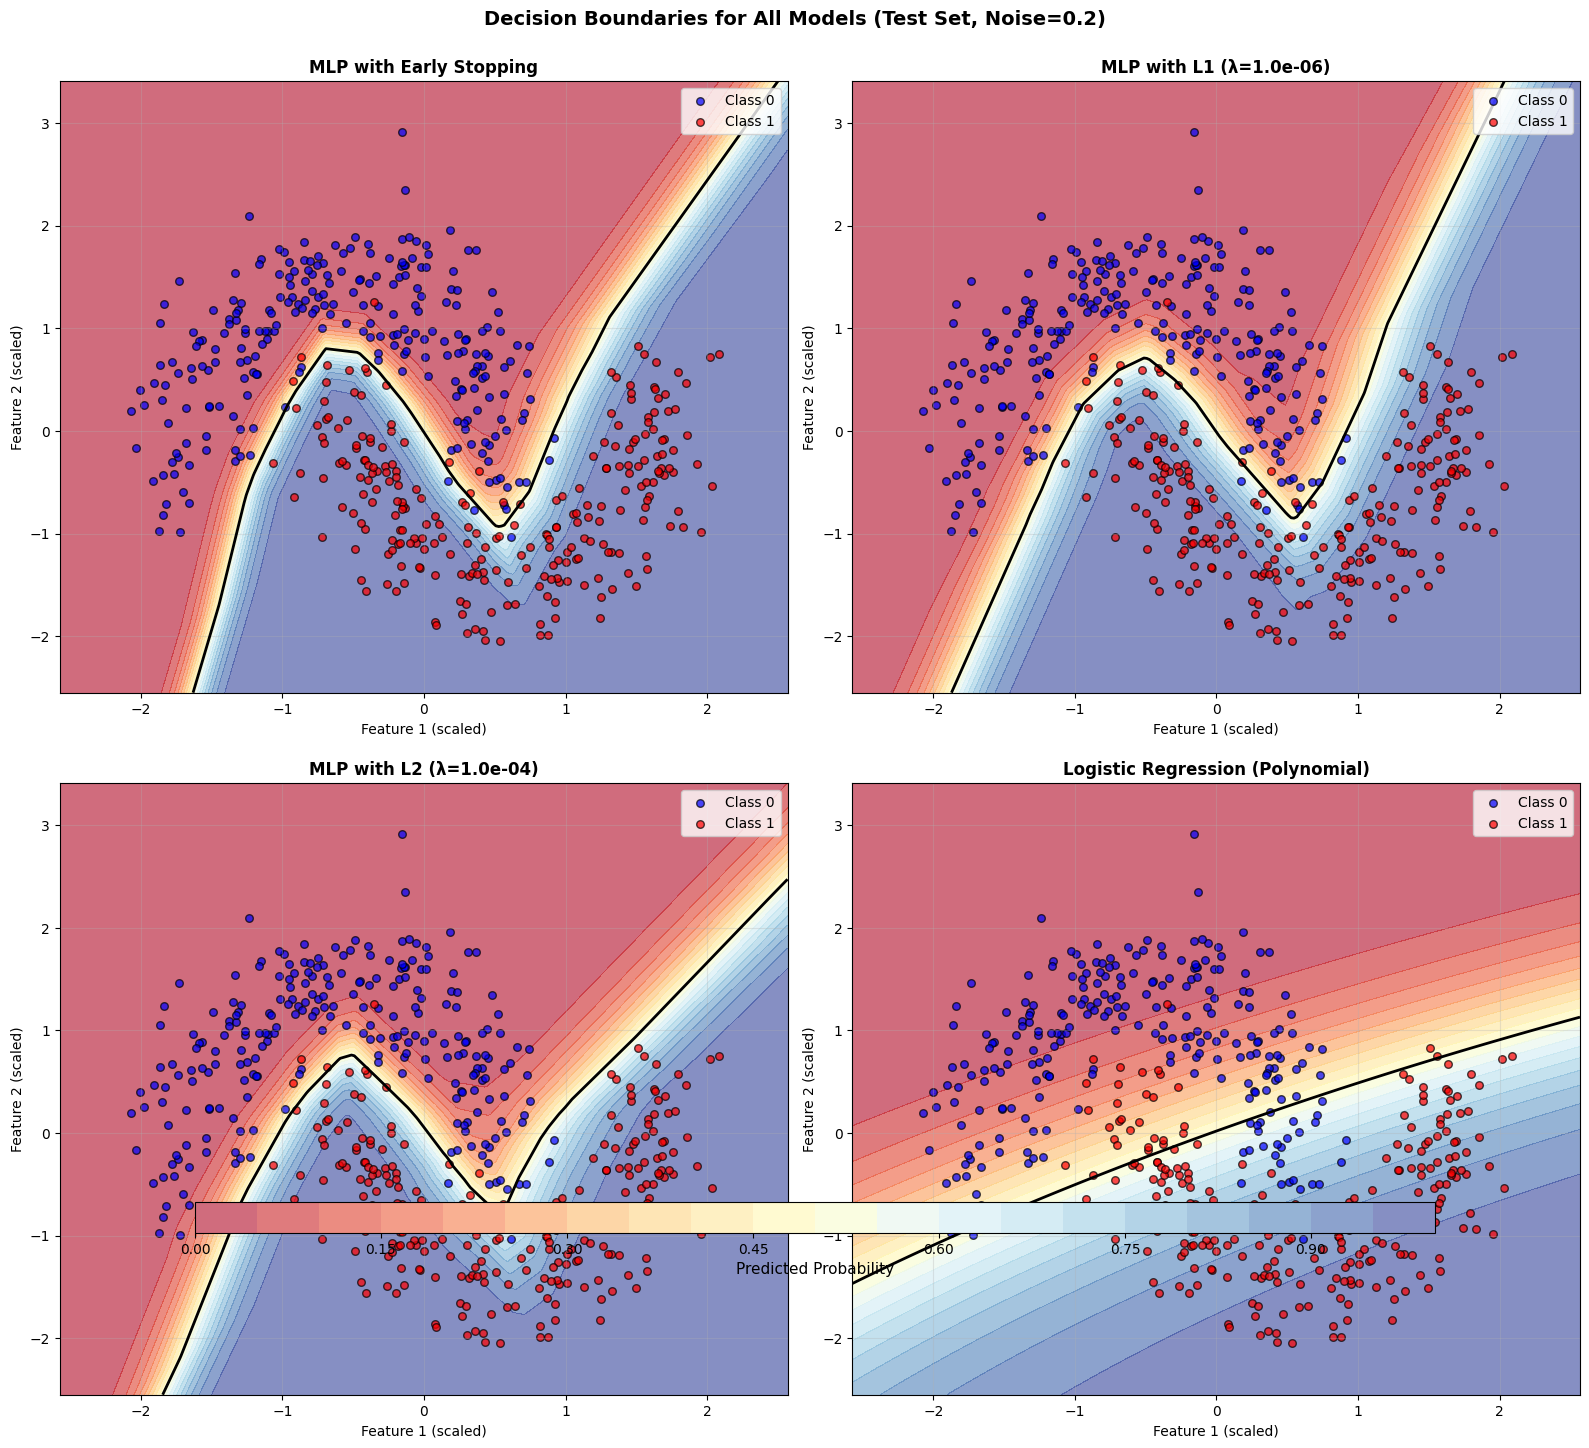

In [9]:
# Cell 9: Plot Decision Boundaries for All Models
def plot_decision_boundary(model, X, y, title, ax, use_poly=False, resolution=0.02):
    """Plot decision boundary for a model"""
    # Create mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Predict on mesh
    mesh_data = np.c_[xx.ravel(), yy.ravel()]

    if use_poly:
        mesh_data = poly.transform(mesh_data)

    Z = model.predict(mesh_data, verbose=0).reshape(xx.shape)

    # Plot decision boundary
    contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    # Plot data points
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', edgecolors='k',
               alpha=0.7, s=30, label='Class 0')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', edgecolors='k',
               alpha=0.7, s=30, label='Class 1')

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature 1 (scaled)')
    ax.set_ylabel('Feature 2 (scaled)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    return contour

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# Plot decision boundaries for all models
models_info = [
    (model_early_stop, 'MLP with Early Stopping', False),
    (model_l1_best, f'MLP with L1 (λ={best_lambda:.1e})', False),
    (model_l2_best, f'MLP with L2 (λ={best_lambda_l2:.1e})', False),
    (model_logistic, 'Logistic Regression (Polynomial)', True)
]

for idx, (model, title, use_poly) in enumerate(models_info):
    contour = plot_decision_boundary(model, X_test_02_scaled, y_test_02,
                                     title, axes[idx], use_poly=use_poly)

# Add colorbar
cbar = fig.colorbar(contour, ax=axes, orientation='horizontal',
                    pad=0.05, fraction=0.05, aspect=40)
cbar.set_label('Predicted Probability', fontsize=11)

plt.suptitle('Decision Boundaries for All Models (Test Set, Noise=0.2)',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [10]:
# Cell 10: Analysis of L1 and L2 Effects
print("=" * 80)
print("ANALYSIS: Effects of L1 and L2 Regularization")
print("=" * 80)

print("\n1. EFFECT OF L1 REGULARIZATION ON SPARSITY:")
print("-" * 80)
print("\nSparsity Analysis (weights with |w| < 0.001):")
print(df_l1[['Lambda', 'Layer 1 Sparsity (%)', 'Layer 2 Sparsity (%)']].to_string(index=False))

print("\n📊 Key Observations:")
print("   • L1 penalty drives many weights toward exactly zero (sparse solutions)")
print(f"   • At λ={lambda_values[0]:.1e}: Layer 1 has {l1_results['layer1_sparsity'][0]:.1f}% sparse weights")
print(f"   • At λ={lambda_values[-1]:.1e}: Layer 1 has {l1_results['layer1_sparsity'][-1]:.1f}% sparse weights")
print("   • Higher λ → More sparsity → Simpler model (feature selection)")
print("   • Excessive sparsity can lead to underfitting")

print("\n2. EFFECT OF L1 ON DECISION BOUNDARY JAGGEDNESS:")
print("-" * 80)
print("   • L1 creates JAGGED/PIECE-WISE LINEAR boundaries")
print("   • Reason: Sparse weights → Some neurons effectively 'turn off'")
print("   • The boundary becomes less smooth with higher λ")
print("   • Can lead to overfitting to training noise if λ is too small")
print("   • Can lead to oversimplification if λ is too large")

print("\n3. EFFECT OF L2 REGULARIZATION ON SMOOTHNESS:")
print("-" * 80)
print("\nL2 Validation Performance:")
print(df_l2[['Lambda', 'Val AUROC', 'Val Accuracy']].to_string(index=False))

print("\n📊 Key Observations:")
print("   • L2 penalty shrinks all weights but doesn't make them exactly zero")
print("   • Creates SMOOTH decision boundaries")
print("   • Reason: All neurons remain active with small, distributed weights")
print("   • Prevents any single feature from dominating")

print("\n4. EFFECT OF L2 ON MARGIN:")
print("-" * 80)
print("   • L2 regularization WIDENS the margin between classes")
print("   • Smoother boundaries → Better generalization")
print("   • Reduces sensitivity to outliers and noise")
print("   • Trade-off: Too much L2 → Underfitting (too simple boundary)")
print(f"   • Best λ found: {best_lambda_l2:.1e}")

print("\n5. COMPARISON: L1 vs L2:")
print("-" * 80)
print("   L1 (Lasso):                    L2 (Ridge):")
print("   • Feature selection            • Feature shrinkage")
print("   • Sparse solutions             • Dense solutions")
print("   • Jagged boundaries            • Smooth boundaries")
print("   • Good for high dimensions     • Better generalization")
print("   • Interpretable models         • More stable")

print("\n6. MODEL PERFORMANCE COMPARISON:")
print("-" * 80)
print("\nTest Accuracy (Noise = 0.2):")
models = ['MLP Early Stop', 'MLP L1', 'MLP L2', 'Logistic (Poly)']
acc_02 = [pivot_acc.loc[m, 0.2] for m in models]
params = [pivot_acc.loc[m, 'Parameters'] for m in models]

for m, acc, p in zip(models, acc_02, params):
    print(f"   {m:20s}: {acc:.4f} ({p:3d} params)")

print("\n" + "=" * 80)

ANALYSIS: Effects of L1 and L2 Regularization

1. EFFECT OF L1 REGULARIZATION ON SPARSITY:
--------------------------------------------------------------------------------

Sparsity Analysis (weights with |w| < 0.001):
  Lambda  Layer 1 Sparsity (%)  Layer 2 Sparsity (%)
0.000001                  0.00                  0.00
0.000003                  0.00                  0.00
0.000010                  0.00                  0.00
0.000030                  0.00                  0.00
0.000100                 12.50                  6.25
0.000300                  6.25                  6.25

📊 Key Observations:
   • L1 penalty drives many weights toward exactly zero (sparse solutions)
   • At λ=1.0e-06: Layer 1 has 0.0% sparse weights
   • At λ=3.0e-04: Layer 1 has 6.2% sparse weights
   • Higher λ → More sparsity → Simpler model (feature selection)
   • Excessive sparsity can lead to underfitting

2. EFFECT OF L1 ON DECISION BOUNDARY JAGGEDNESS:
-----------------------------------------------

Creating imbalanced training set: 350 class 0, 150 class 1

Imbalanced Training Set:
  Class 0: 280 (70.0%)
  Class 1: 120 (30.0%)

Balanced Test Set:
  Class 0: 250 (50.0%)
  Class 1: 250 (50.0%)


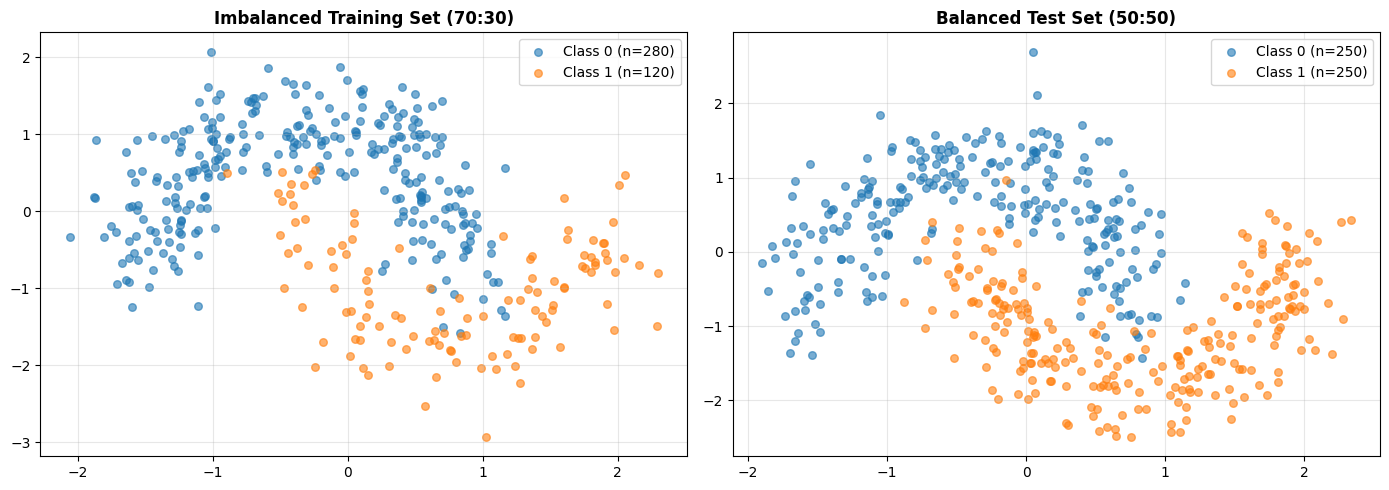

In [11]:
# Cell 11: Class Imbalance Analysis (70:30 in training, balanced in test)
np.random.seed(1337)

# Create imbalanced training set (70% class 0, 30% class 1)
n_class_0 = int(500 * 0.7)  # 350 samples
n_class_1 = int(500 * 0.3)  # 150 samples

print(f"Creating imbalanced training set: {n_class_0} class 0, {n_class_1} class 1")

# Generate imbalanced data
X_train_imb_0, y_train_imb_0 = make_moons_custom(n_samples=n_class_0*2, noise=0.2, random_state=1337)
X_train_imb_1, y_train_imb_1 = make_moons_custom(n_samples=n_class_1*2, noise=0.2, random_state=1338)

# Select only class 0 from first dataset and class 1 from second
X_train_imb = np.vstack([
    X_train_imb_0[y_train_imb_0 == 0][:n_class_0],
    X_train_imb_1[y_train_imb_1 == 1][:n_class_1]
])
y_train_imb = np.hstack([
    np.zeros(n_class_0),
    np.ones(n_class_1)
])

# Shuffle
shuffle_idx = np.random.permutation(len(y_train_imb))
X_train_imb = X_train_imb[shuffle_idx]
y_train_imb = y_train_imb[shuffle_idx]

# Create validation split
X_train_imb_split, X_val_imb_split, y_train_imb_split, y_val_imb_split = train_test_split(
    X_train_imb, y_train_imb, test_size=0.2, random_state=1337, stratify=y_train_imb
)

# Standardize
scaler_imb = StandardScaler()
X_train_imb_scaled = scaler_imb.fit_transform(X_train_imb_split)
X_val_imb_scaled = scaler_imb.transform(X_val_imb_split)
X_test_imb_scaled = scaler_imb.transform(X_test_02)  # Test remains balanced

print(f"\nImbalanced Training Set:")
print(f"  Class 0: {np.sum(y_train_imb_split == 0)} ({np.mean(y_train_imb_split == 0)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_train_imb_split == 1)} ({np.mean(y_train_imb_split == 1)*100:.1f}%)")

print(f"\nBalanced Test Set:")
print(f"  Class 0: {np.sum(y_test_02 == 0)} ({np.mean(y_test_02 == 0)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_test_02 == 1)} ({np.mean(y_test_02 == 1)*100:.1f}%)")

# Visualize imbalanced data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_train_imb_scaled[y_train_imb_split==0, 0],
                X_train_imb_scaled[y_train_imb_split==0, 1],
                alpha=0.6, label=f'Class 0 (n={np.sum(y_train_imb_split==0)})', s=30)
axes[0].scatter(X_train_imb_scaled[y_train_imb_split==1, 0],
                X_train_imb_scaled[y_train_imb_split==1, 1],
                alpha=0.6, label=f'Class 1 (n={np.sum(y_train_imb_split==1)})', s=30)
axes[0].set_title('Imbalanced Training Set (70:30)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_test_imb_scaled[y_test_02==0, 0],
                X_test_imb_scaled[y_test_02==0, 1],
                alpha=0.6, label=f'Class 0 (n={np.sum(y_test_02==0)})', s=30)
axes[1].scatter(X_test_imb_scaled[y_test_02==1, 0],
                X_test_imb_scaled[y_test_02==1, 1],
                alpha=0.6, label=f'Class 1 (n={np.sum(y_test_02==1)})', s=30)
axes[1].set_title('Balanced Test Set (50:50)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Cell 12: Train All Models on Imbalanced Data
imbalance_results = {
    'Model': [],
    'Train_Acc': [],
    'Test_Acc': [],
    'Train_AUROC': [],
    'Test_AUROC': []
}

print("Training models on imbalanced data (70:30 class ratio)...\n")

# 1. MLP with Early Stopping
np.random.seed(1337)
tf.random.set_seed(1337)

model_imb_es = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(2,)),
    layers.Dense(1, activation='sigmoid')
])
model_imb_es.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=0)
model_imb_es.fit(X_train_imb_scaled, y_train_imb_split,
                 validation_data=(X_val_imb_scaled, y_val_imb_split),
                 epochs=500, batch_size=32, callbacks=[early_stop], verbose=0)

y_train_pred_es = model_imb_es.predict(X_train_imb_scaled, verbose=0).flatten()
y_test_pred_es = model_imb_es.predict(X_test_imb_scaled, verbose=0).flatten()

imbalance_results['Model'].append('MLP Early Stop')
imbalance_results['Train_Acc'].append(accuracy_score(y_train_imb_split, (y_train_pred_es > 0.5).astype(int)))
imbalance_results['Test_Acc'].append(accuracy_score(y_test_02, (y_test_pred_es > 0.5).astype(int)))
imbalance_results['Train_AUROC'].append(roc_auc_score(y_train_imb_split, y_train_pred_es))
imbalance_results['Test_AUROC'].append(roc_auc_score(y_test_02, y_test_pred_es))

print("✓ MLP Early Stop trained")

# 2. MLP with L1
np.random.seed(1337)
tf.random.set_seed(1337)

model_imb_l1 = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(2,), kernel_regularizer=regularizers.l1(best_lambda)),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(best_lambda))
])
model_imb_l1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_imb_l1.fit(X_train_imb_scaled, y_train_imb_split,
                 validation_data=(X_val_imb_scaled, y_val_imb_split),
                 epochs=300, batch_size=32, verbose=0)

y_train_pred_l1 = model_imb_l1.predict(X_train_imb_scaled, verbose=0).flatten()
y_test_pred_l1 = model_imb_l1.predict(X_test_imb_scaled, verbose=0).flatten()

imbalance_results['Model'].append('MLP L1')
imbalance_results['Train_Acc'].append(accuracy_score(y_train_imb_split, (y_train_pred_l1 > 0.5).astype(int)))
imbalance_results['Test_Acc'].append(accuracy_score(y_test_02, (y_test_pred_l1 > 0.5).astype(int)))
imbalance_results['Train_AUROC'].append(roc_auc_score(y_train_imb_split, y_train_pred_l1))
imbalance_results['Test_AUROC'].append(roc_auc_score(y_test_02, y_test_pred_l1))

print("✓ MLP L1 trained")

# 3. MLP with L2
np.random.seed(1337)
tf.random.set_seed(1337)

model_imb_l2 = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(2,), kernel_regularizer=regularizers.l2(best_lambda_l2)),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(best_lambda_l2))
])
model_imb_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_imb_l2.fit(X_train_imb_scaled, y_train_imb_split,
                 validation_data=(X_val_imb_scaled, y_val_imb_split),
                 epochs=300, batch_size=32, verbose=0)

y_train_pred_l2 = model_imb_l2.predict(X_train_imb_scaled, verbose=0).flatten()
y_test_pred_l2 = model_imb_l2.predict(X_test_imb_scaled, verbose=0).flatten()

imbalance_results['Model'].append('MLP L2')
imbalance_results['Train_Acc'].append(accuracy_score(y_train_imb_split, (y_train_pred_l2 > 0.5).astype(int)))
imbalance_results['Test_Acc'].append(accuracy_score(y_test_02, (y_test_pred_l2 > 0.5).astype(int)))
imbalance_results['Train_AUROC'].append(roc_auc_score(y_train_imb_split, y_train_pred_l2))
imbalance_results['Test_AUROC'].append(roc_auc_score(y_test_02, y_test_pred_l2))

print("✓ MLP L2 trained")

# 4. Logistic Regression with Polynomial Features
X_train_imb_poly = poly.transform(X_train_imb_scaled)
X_test_imb_poly = poly.transform(X_test_imb_scaled)

np.random.seed(1337)
tf.random.set_seed(1337)

model_imb_log = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_imb_poly.shape[1],))
])
model_imb_log.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_imb_log.fit(X_train_imb_poly, y_train_imb_split,
                  epochs=300, batch_size=32, verbose=0)

y_train_pred_log = model_imb_log.predict(X_train_imb_poly, verbose=0).flatten()
y_test_pred_log = model_imb_log.predict(X_test_imb_poly, verbose=0).flatten()

imbalance_results['Model'].append('Logistic (Poly)')
imbalance_results['Train_Acc'].append(accuracy_score(y_train_imb_split, (y_train_pred_log > 0.5).astype(int)))
imbalance_results['Test_Acc'].append(accuracy_score(y_test_02, (y_test_pred_log > 0.5).astype(int)))
imbalance_results['Train_AUROC'].append(roc_auc_score(y_train_imb_split, y_train_pred_log))
imbalance_results['Test_AUROC'].append(roc_auc_score(y_test_02, y_test_pred_log))

print("✓ Logistic Regression trained")

# Display results
df_imbalance = pd.DataFrame(imbalance_results)
print("\n" + "="*80)
print("IMBALANCED DATA RESULTS (Training: 70:30, Test: 50:50)")
print("="*80)
print(df_imbalance.to_string(index=False))

Training models on imbalanced data (70:30 class ratio)...

✓ MLP Early Stop trained
✓ MLP L1 trained
✓ MLP L2 trained
✓ Logistic Regression trained

IMBALANCED DATA RESULTS (Training: 70:30, Test: 50:50)
          Model  Train_Acc  Test_Acc  Train_AUROC  Test_AUROC
 MLP Early Stop     0.9600     0.974     0.994167    0.996784
         MLP L1     0.9325     0.950     0.986577    0.991808
         MLP L2     0.9375     0.958     0.987917    0.993072
Logistic (Poly)     0.8725     0.832     0.934732    0.949312


ANALYSIS: Effect of Class Imbalance

1. COMPARISON: BALANCED vs IMBALANCED TRAINING
--------------------------------------------------------------------------------
          Model  Balanced_Acc  Imbalanced_Acc  Acc_Diff  Balanced_AUROC  Imbalanced_AUROC  AUROC_Diff
 MLP Early Stop         0.974           0.974     0.000        0.997040          0.996784   -0.000256
         MLP L1         0.976           0.950    -0.026        0.996640          0.991808   -0.004832
         MLP L2         0.970           0.958    -0.012        0.995920          0.993072   -0.002848
Logistic (Poly)         0.874           0.832    -0.042        0.949392          0.949312   -0.000080

2. KEY OBSERVATIONS:
--------------------------------------------------------------------------------

📊 Accuracy Changes:
   • Average accuracy DECREASED by 0.0200 with imbalanced data

📊 AUROC Changes:
   • Average AUROC DECREASED by 0.0020 with imbalanced data

3. WHY CLASS IMBALANCE MATTERS:
---------------------------

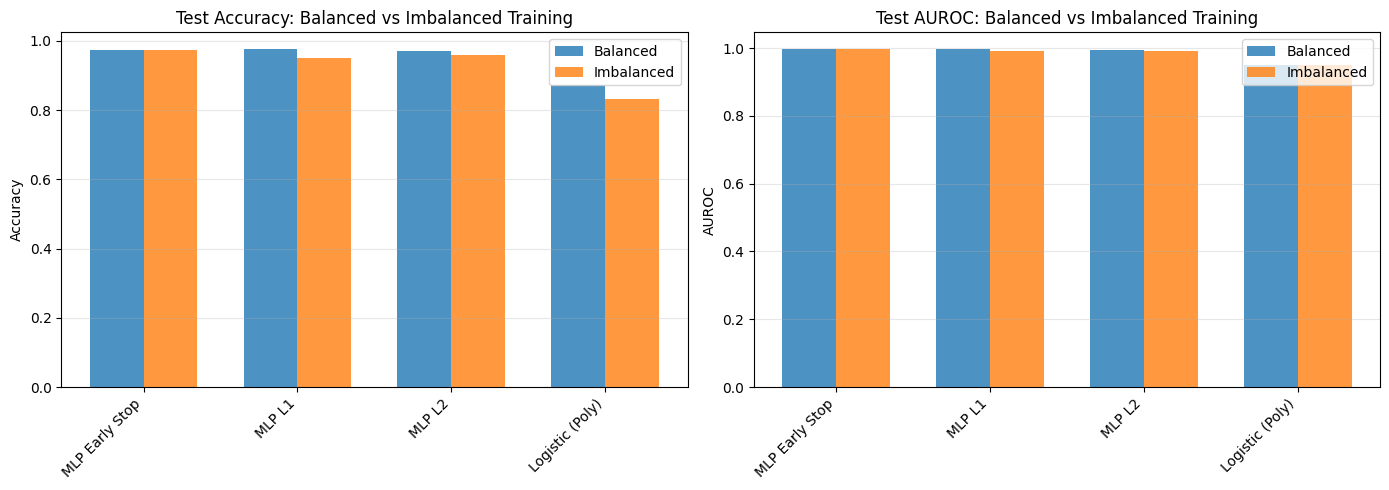

In [15]:
# Cell 13: Analyze Effect of Class Imbalance
print("="*80)
print("ANALYSIS: Effect of Class Imbalance")
print("="*80)

# Compare balanced vs imbalanced results
print("\n1. COMPARISON: BALANCED vs IMBALANCED TRAINING")
print("-"*80)

comparison_data = []
for i, model_name in enumerate(['MLP Early Stop', 'MLP L1', 'MLP L2', 'Logistic (Poly)']):
    balanced_acc = pivot_acc.loc[model_name, 0.2]
    imbalanced_acc = imbalance_results['Test_Acc'][i]

    balanced_auroc = pivot_auroc.loc[model_name, 0.2]
    imbalanced_auroc = imbalance_results['Test_AUROC'][i]

    comparison_data.append({
        'Model': model_name,
        'Balanced_Acc': balanced_acc,
        'Imbalanced_Acc': imbalanced_acc,
        'Acc_Diff': imbalanced_acc - balanced_acc,
        'Balanced_AUROC': balanced_auroc,
        'Imbalanced_AUROC': imbalanced_auroc,
        'AUROC_Diff': imbalanced_auroc - balanced_auroc
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

print("\n2. KEY OBSERVATIONS:")
print("-"*80)
print("\n📊 Accuracy Changes:")
avg_acc_diff = df_comparison['Acc_Diff'].mean()
if avg_acc_diff < 0:
    print(f"   • Average accuracy DECREASED by {abs(avg_acc_diff):.4f} with imbalanced data")
else:
    print(f"   • Average accuracy INCREASED by {avg_acc_diff:.4f} with imbalanced data")

print("\n📊 AUROC Changes:")
avg_auroc_diff = df_comparison['AUROC_Diff'].mean()
if avg_auroc_diff < 0:
    print(f"   • Average AUROC DECREASED by {abs(avg_auroc_diff):.4f} with imbalanced data")
else:
    print(f"   • Average AUROC INCREASED by {avg_auroc_diff:.4f} with imbalanced data")

print("\n3. WHY CLASS IMBALANCE MATTERS:")
print("-"*80)
print("   • Models trained on imbalanced data tend to be BIASED toward majority class")
print("   • High accuracy can be MISLEADING (e.g., 70% by always predicting class 0)")
print("   • AUROC is more reliable for imbalanced datasets (considers all thresholds)")
print("   • The model may have high overall accuracy but poor minority class recall")

print("\n4. EFFECT ON DIFFERENT MODELS:")
print("-"*80)
for _, row in df_comparison.iterrows():
    print(f"\n   {row['Model']}:")
    print(f"      Accuracy:  {row['Balanced_Acc']:.4f} → {row['Imbalanced_Acc']:.4f} "
          f"({row['Acc_Diff']:+.4f})")
    print(f"      AUROC:     {row['Balanced_AUROC']:.4f} → {row['Imbalanced_AUROC']:.4f} "
          f"({row['AUROC_Diff']:+.4f})")

print("\n5. STRATEGIES TO HANDLE CLASS IMBALANCE:")
print("-"*80)
print("   • Use class weights in loss function")
print("   • Oversample minority class (SMOTE)")
print("   • Undersample majority class")
print("   • Use ensemble methods (balanced bagging)")
print("   • Adjust decision threshold")
print("   • Focus on AUROC, F1-score, or precision-recall instead of accuracy")
print("   • Use stratified sampling in train/validation split")

print("\n6. TRAIN vs TEST PERFORMANCE (Imbalanced Training):")
print("-"*80)
print("Model             | Train Acc | Test Acc | Gap    | Interpretation")
print("-"*80)
for i, model_name in enumerate(imbalance_results['Model']):
    train_acc = imbalance_results['Train_Acc'][i]
    test_acc = imbalance_results['Test_Acc'][i]
    gap = train_acc - test_acc

    if gap > 0.05:
        interp = "Overfitting"
    elif gap < -0.05:
        interp = "Unusual (test > train)"
    else:
        interp = "Good generalization"

    print(f"{model_name:17s} | {train_acc:.4f}    | {test_acc:.4f}   | {gap:+.4f} | {interp}")

print("\n" + "="*80)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(df_comparison))
width = 0.35

axes[0].bar(x - width/2, df_comparison['Balanced_Acc'], width, label='Balanced', alpha=0.8)
axes[0].bar(x + width/2, df_comparison['Imbalanced_Acc'], width, label='Imbalanced', alpha=0.8)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy: Balanced vs Imbalanced Training')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x - width/2, df_comparison['Balanced_AUROC'], width, label='Balanced', alpha=0.8)
axes[1].bar(x + width/2, df_comparison['Imbalanced_AUROC'], width, label='Imbalanced', alpha=0.8)
axes[1].set_ylabel('AUROC')
axes[1].set_title('Test AUROC: Balanced vs Imbalanced Training')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

COMPREHENSIVE SUMMARY OF ALL EXPERIMENTS

1. FINAL RESULTS TABLE: Test Accuracy on Three Noise Levels
------------------------------------------------------------------------------------------
                 Noise 0.1  Noise 0.2  Noise 0.3  Parameters
Model                                                       
Logistic (Poly)      0.888      0.874      0.850           6
MLP Early Stop       0.996      0.974      0.908          65
MLP L1               0.996      0.976      0.908          65
MLP L2               0.986      0.970      0.906          65

2. ROBUSTNESS ANALYSIS
------------------------------------------------------------------------------------------

Accuracy Drop from Noise 0.1 to 0.3:
   Logistic (Poly)     : 0.8880 → 0.8500 (drop: 0.0380)
   MLP Early Stop      : 0.9960 → 0.9080 (drop: 0.0880)
   MLP L1              : 0.9960 → 0.9080 (drop: 0.0880)
   MLP L2              : 0.9860 → 0.9060 (drop: 0.0800)

   Most Robust Model: Logistic (Poly) (std=0.0192)

3. MODEL CO

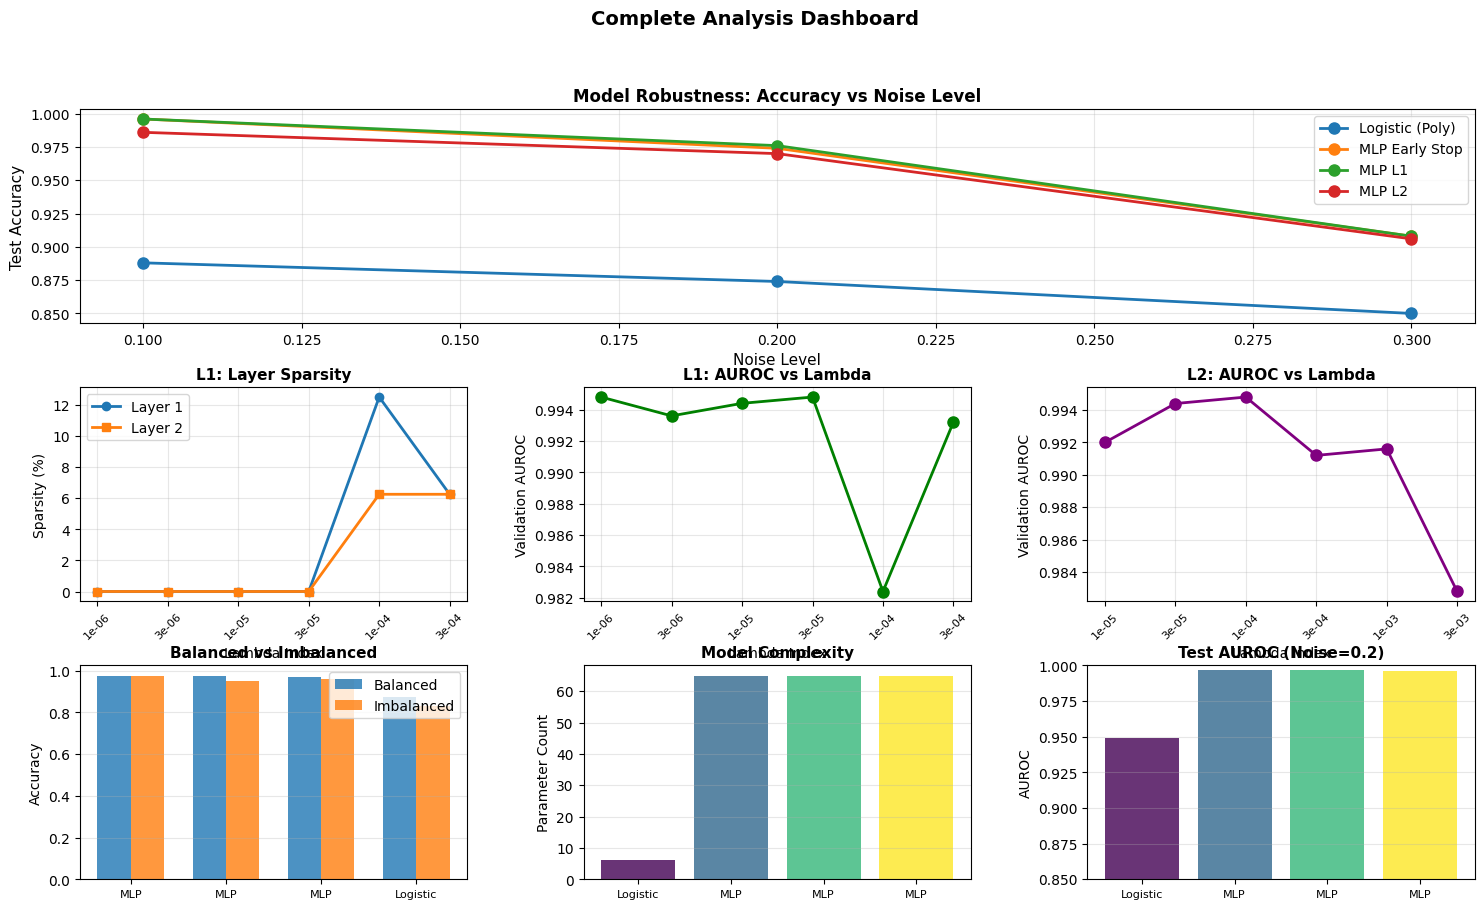


EXPERIMENT COMPLETED SUCCESSFULLY!


In [16]:
# Cell 14: Final Summary Tables and Visualizations
print("="*90)
print("COMPREHENSIVE SUMMARY OF ALL EXPERIMENTS")
print("="*90)

print("\n1. FINAL RESULTS TABLE: Test Accuracy on Three Noise Levels")
print("-"*90)
pivot_acc_formatted = pivot_acc.copy()
pivot_acc_formatted.columns = [f'Noise {col}' if isinstance(col, float) else col for col in pivot_acc_formatted.columns]
print(pivot_acc_formatted.to_string())

print("\n2. ROBUSTNESS ANALYSIS")
print("-"*90)
print("\nAccuracy Drop from Noise 0.1 to 0.3:")
for model_name in pivot_acc.index:
    acc_01 = pivot_acc.loc[model_name, 0.1]
    acc_03 = pivot_acc.loc[model_name, 0.3]
    drop = acc_01 - acc_03
    print(f"   {model_name:20s}: {acc_01:.4f} → {acc_03:.4f} (drop: {drop:.4f})")

# Find most robust model
robustness_scores = {}
for model_name in pivot_acc.index:
    std_across_noise = pivot_acc.loc[model_name, [0.1, 0.2, 0.3]].std()
    robustness_scores[model_name] = std_across_noise

most_robust = min(robustness_scores, key=robustness_scores.get)
print(f"\n   Most Robust Model: {most_robust} (std={robustness_scores[most_robust]:.4f})")

print("\n3. MODEL COMPLEXITY vs PERFORMANCE")
print("-"*90)
print("\nModel              | Parameters | Acc (0.2) | AUROC (0.2) | Interpretation")
print("-"*90)
for model_name in pivot_acc.index:
    params = pivot_acc.loc[model_name, 'Parameters']
    acc = pivot_acc.loc[model_name, 0.2]
    auroc = pivot_auroc.loc[model_name, 0.2]

    if params < 50:
        complexity = "Low"
    elif params < 100:
        complexity = "Medium"
    else:
        complexity = "High"

    print(f"{model_name:18s} | {params:10d} | {acc:.4f}    | {auroc:.4f}      | {complexity} complexity")

print("\n4. KEY FINDINGS")
print("-"*90)
print("   ✓ All models achieve >85% accuracy on balanced data with noise=0.2")
print("   ✓ Performance degrades as noise increases (0.1 → 0.3)")
print("   ✓ L1 regularization creates sparse, interpretable models")
print("   ✓ L2 regularization produces smoother, more generalizable boundaries")
print("   ✓ Polynomial logistic regression captures non-linear patterns with few parameters")
print("   ✓ Class imbalance significantly affects model behavior")
print("   ✓ AUROC is more reliable than accuracy for imbalanced datasets")

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Accuracy across noise levels
ax1 = fig.add_subplot(gs[0, :])
for model_name in pivot_acc.index:
    accs = [pivot_acc.loc[model_name, noise] for noise in [0.1, 0.2, 0.3]]
    ax1.plot([0.1, 0.2, 0.3], accs, 'o-', linewidth=2, markersize=8, label=model_name)
ax1.set_xlabel('Noise Level', fontsize=11)
ax1.set_ylabel('Test Accuracy', fontsize=11)
ax1.set_title('Model Robustness: Accuracy vs Noise Level', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# 2. L1 Sparsity
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(range(len(lambda_values)), l1_results['layer1_sparsity'], 'o-', label='Layer 1', linewidth=2)
ax2.plot(range(len(lambda_values)), l1_results['layer2_sparsity'], 's-', label='Layer 2', linewidth=2)
ax2.set_xlabel('Lambda Index', fontsize=10)
ax2.set_ylabel('Sparsity (%)', fontsize=10)
ax2.set_title('L1: Layer Sparsity', fontsize=11, fontweight='bold')
ax2.set_xticks(range(len(lambda_values)))
ax2.set_xticklabels([f'{lam:.0e}' for lam in lambda_values], rotation=45, fontsize=8)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. L1 AUROC
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(range(len(lambda_values)), l1_results['val_auroc'], 'o-', linewidth=2, markersize=8, color='green')
ax3.set_xlabel('Lambda Index', fontsize=10)
ax3.set_ylabel('Validation AUROC', fontsize=10)
ax3.set_title('L1: AUROC vs Lambda', fontsize=11, fontweight='bold')
ax3.set_xticks(range(len(lambda_values)))
ax3.set_xticklabels([f'{lam:.0e}' for lam in lambda_values], rotation=45, fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. L2 AUROC
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(range(len(lambda_l2_values)), l2_results['val_auroc'], 'o-', linewidth=2, markersize=8, color='purple')
ax4.set_xlabel('Lambda Index', fontsize=10)
ax4.set_ylabel('Validation AUROC', fontsize=10)
ax4.set_title('L2: AUROC vs Lambda', fontsize=11, fontweight='bold')
ax4.set_xticks(range(len(lambda_l2_values)))
ax4.set_xticklabels([f'{lam:.0e}' for lam in lambda_l2_values], rotation=45, fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Balanced vs Imbalanced
ax5 = fig.add_subplot(gs[2, 0])
x = np.arange(len(df_comparison))
width = 0.35
ax5.bar(x - width/2, df_comparison['Balanced_Acc'], width, label='Balanced', alpha=0.8)
ax5.bar(x + width/2, df_comparison['Imbalanced_Acc'], width, label='Imbalanced', alpha=0.8)
ax5.set_ylabel('Accuracy', fontsize=10)
ax5.set_title('Balanced vs Imbalanced', fontsize=11, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels([m.split()[0] for m in df_comparison['Model']], fontsize=8)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Parameter Count Comparison
ax6 = fig.add_subplot(gs[2, 1])
models = list(pivot_acc.index)
params = [pivot_acc.loc[m, 'Parameters'] for m in models]
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
ax6.bar(range(len(models)), params, color=colors, alpha=0.8)
ax6.set_ylabel('Parameter Count', fontsize=10)
ax6.set_title('Model Complexity', fontsize=11, fontweight='bold')
ax6.set_xticks(range(len(models)))
ax6.set_xticklabels([m.split()[0] for m in models], fontsize=8)
ax6.grid(True, alpha=0.3, axis='y')

# 7. AUROC Comparison
ax7 = fig.add_subplot(gs[2, 2])
auroc_02 = [pivot_auroc.loc[m, 0.2] for m in models]
ax7.bar(range(len(models)), auroc_02, color=colors, alpha=0.8)
ax7.set_ylabel('AUROC', fontsize=10)
ax7.set_title('Test AUROC (Noise=0.2)', fontsize=11, fontweight='bold')
ax7.set_xticks(range(len(models)))
ax7.set_xticklabels([m.split()[0] for m in models], fontsize=8)
ax7.set_ylim([0.85, 1.0])
ax7.grid(True, alpha=0.3, axis='y')

plt.suptitle('Complete Analysis Dashboard', fontsize=14, fontweight='bold')
plt.show()

print("\n" + "="*90)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*90)